# Procrastinate Pro+


<div class="alert alert-info"> <b>Procrastinate Pro+ это развлекательное приложение.   
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.   
Задача — разобраться в причинах и помочь компании выйти в плюс.</b>

## Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits, orders, costs  = (
    pd.read_csv("C:/Users/Irina/Downloads/visits_info_short.csv"), # информация о посещениях сайта
    pd.read_csv("C:/Users/Irina/Downloads/orders_info_short.csv"), # информация о заказах
    pd.read_csv("C:/Users/Irina/Downloads/costs_info_short.csv"), # информация о расходах на рекламу
)
except: 
    visits, orders, costs  = (
    pd.read_csv("/datasets/visits_info_short.csv"), # информация о посещениях сайта
    pd.read_csv("/datasets/orders_info_short.csv"), # информация о заказах
    pd.read_csv("/datasets/costs_info_short.csv"), # информация о расходах на рекламу
)

In [3]:
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

Приведем названия столбцов в удобный формат

In [58]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

In [5]:
orders.head()

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [6]:
costs.head()

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Преобразуем данные о времени

In [10]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

ДУбликатов и пропущенных значений нет


## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

In [11]:

# функция для создания пользовательских профилей


def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

   # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    # объединяем траты на рекламу и число привлечённых пользователей
    costs['dt'] = costs['dt'].dt.date
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] =  costs['costs'] /  costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    

    return profiles
 

In [12]:
 # функция для расчета Ration Rate

def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
# Функции для расчета конверсии

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
       orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [14]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

In [19]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [20]:
# определяем минимальную и максимальную дату привлечения пользователей 

dt_min = profiles['dt'].min()

dt_max = profiles['dt'].max()

print (dt_min, dt_max)

2019-05-01 2019-10-27


Мы обладаем данными с 1-го мая по 27 октября 2019 года

In [21]:
country_users = (profiles.groupby(by='region')
    .agg(total_users=('user_id', 'nunique'), total_payers=('payer', 'sum'), payer_ratio=('payer', 'mean')).sort_values(by='payer_ratio', ascending=False)
)
country_users

total_users  total_payers  payer_ratio
region                                               
United States       100002          6902     0.069019
Germany              14981           616     0.041119
UK                   17575           700     0.039829
France               17450           663     0.037994

В приложения приходят из Франции, Германии, Англии и Америки. При этом доля платящих пользователей выше всего у Америки, при почти одинаковой доли платящих по другим странам

In [22]:
# таблица отражающая долю платящих пользователей из каждой страны
device_users = (profiles.groupby(by='device')
    .agg(total_users=('user_id', 'nunique'), total_payers=('payer', 'sum'), payer_ratio=('payer', 'mean')).sort_values(by='payer_ratio', ascending=False)
)

device_users

total_users  total_payers  payer_ratio
device                                         
Mac            30042          1912     0.063644
iPhone         54479          3382     0.062079
Android        35032          2050     0.058518
PC             30455          1537     0.050468

Доля платящих пользователей с разных устройств примерно одинакова, выше у iphone и mac, самая низкая у PC

In [23]:
channel_users = (profiles.groupby(by='channel')
    .agg(total_users=('user_id', 'nunique'), total_payers=('payer', 'sum'), payer_ratio=('payer', 'mean')).sort_values(by='payer_ratio', ascending=False)
                )                                 


channel_users

total_users  total_payers  payer_ratio
channel                                                   
FaceBoom                  29144          3557     0.122049
AdNonSense                 3880           440     0.113402
lambdaMediaAds             2149           225     0.104700
TipTop                    19561          1878     0.096007
RocketSuperAds             4448           352     0.079137
WahooNetBanner             8553           453     0.052964
YRabbit                    4312           165     0.038265
MediaTornado               4364           156     0.035747
LeapBob                    8553           262     0.030633
OppleCreativeMedia         8605           233     0.027077
organic                   56439          1160     0.020553

Больше всего платящих пользователей приходит из: FaceBoom, AdNonSense, lambdaMediaAds, TipTop

## Маркетинг

Полная сумма расхода на маркетинг

In [24]:
total_marketing = costs['costs']. sum(). round(2)
total_marketing

105497.3

Распределение трат по рекламным источникам

In [25]:
channel_costs = (costs.groupby(by='channel')
    .agg(total_costs = ('costs', 'sum')).sort_values(by='total_costs', ascending=False)

                )                                 
channel_costs

total_costs
channel                        
TipTop                 54751.30
FaceBoom               32445.60
WahooNetBanner          5151.00
AdNonSense              3911.25
OppleCreativeMedia      2151.25
RocketSuperAds          1833.00
LeapBob                 1797.60
lambdaMediaAds          1557.60
MediaTornado             954.48
YRabbit                  944.22

Больше всего трат идет на каналы TipTop, FaceBoom и гораздо меньше на WahooNetBanner.  
Как мы видим из анализа привлеченности покупателей по каналам AdNonSense является очень преспективным каналом, при относительно небольших вложениях, привлекает много покупателей

<AxesSubplot:xlabel='week'>

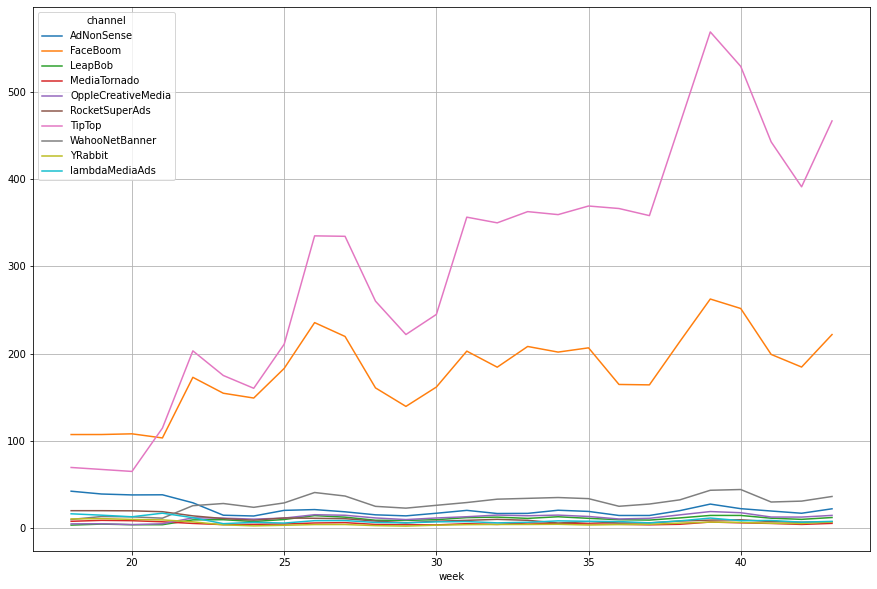

In [26]:
#Динамика изменения расходов во времени по каждому источнику
costs_week_month = costs
costs_week_month['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs_week_month['month'] = pd.to_datetime(costs['dt']).dt.month

costs_week_month.pivot_table(
    index = 'week', columns = 'channel', values = 'costs', aggfunc = 'mean'
).plot(grid = True, figsize = (15,10))



<AxesSubplot:xlabel='month'>

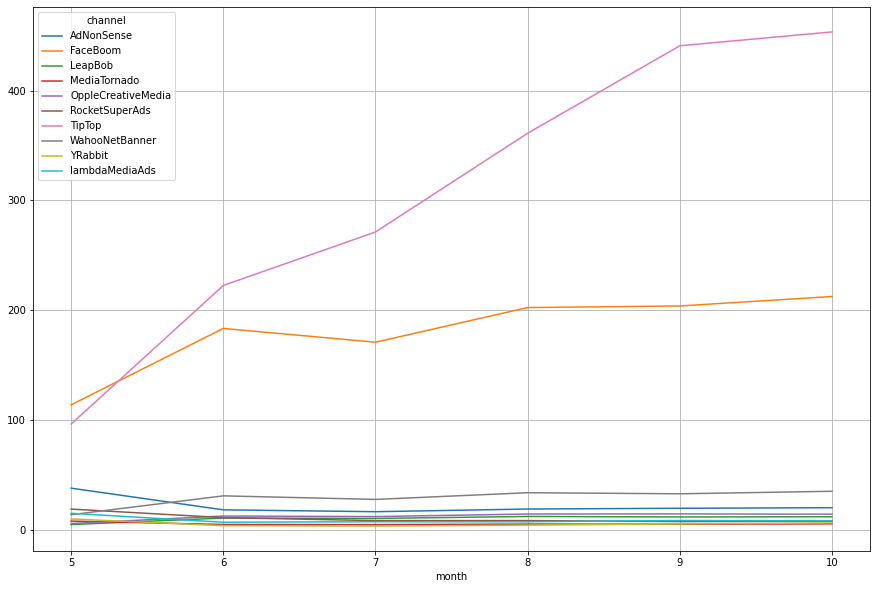

In [27]:
costs_week_month.pivot_table(
    index = 'month', columns = 'channel', values = 'costs', aggfunc = 'mean'
).plot(grid = True, figsize = (15,10))


Затраты на такие каналы привлечения как TipTop и FaceBoom выросли 

In [28]:
# сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean'
)

acquisition_cost
channel                             
AdNonSense                  1.008054
FaceBoom                    1.113286
LeapBob                     0.210172
MediaTornado                0.218717
OppleCreativeMedia          0.250000
RocketSuperAds              0.412095
TipTop                      2.799003
WahooNetBanner              0.602245
YRabbit                     0.218975
lambdaMediaAds              0.724802
organic                     0.000000

У канала TipTop CAC самый высокий, затем больше чем в 2 раза меньше FaceBoom и AdNonSense

In [29]:
# Средний САС по всему проекту
profiles_cac = profiles['acquisition_cost'].mean()

profiles_cac

0.7032778251826568

## Окупаемость рекламы

In [30]:
# Убираем данные по органике
profiles = profiles[~profiles['channel'].isin(['organic'])]
profiles

user_id            first_ts       channel   device  \
0             599326 2019-05-07 20:58:57      FaceBoom      Mac   
1            4919697 2019-07-09 12:46:07      FaceBoom   iPhone   
3           22593348 2019-08-22 21:35:48    AdNonSense       PC   
4           31989216 2019-10-02 00:07:44       YRabbit   iPhone   
7           46006712 2019-06-30 03:46:29    AdNonSense  Android   
...              ...                 ...           ...      ...   
149999  999942424543 2019-05-24 21:03:26        TipTop   iPhone   
150001  999949280903 2019-08-12 06:47:27      FaceBoom      Mac   
150003  999956196527 2019-09-28 08:33:02        TipTop   iPhone   
150005  999976332130 2019-07-23 02:57:06        TipTop   iPhone   
150006  999979924135 2019-09-28 21:28:09  MediaTornado       PC   

               region          dt      month  payer  acquisition_cost  
0       United States  2019-05-07 2019-05-01   True          1.088172  
1       United States  2019-07-09 2019-07-01  False          1.107237  
3             Germany  2019-08-22 2019-08-01  False          0.988235  
4       United States  2019-10-02 2019-10-01  False          0.230769  
7              France  2019-06-30 2019-06-01   True          1.008000  
...               ...         ...        ...    ...               ...  
149999  United States  2019-05-24 2019-05-01  False          1.900000  
150001  United States  2019-08-12 2019-08-01  False          1.117838  
150003  United States  2019-09-28 2019-09-01  False          3.500000  
150005  United States  2019-07-23 2019-07-01  False          2.600000  
150006  United States  2019-09-28 2019-09-01  False          0.205714  

[93569 rows x 9 columns]

In [31]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

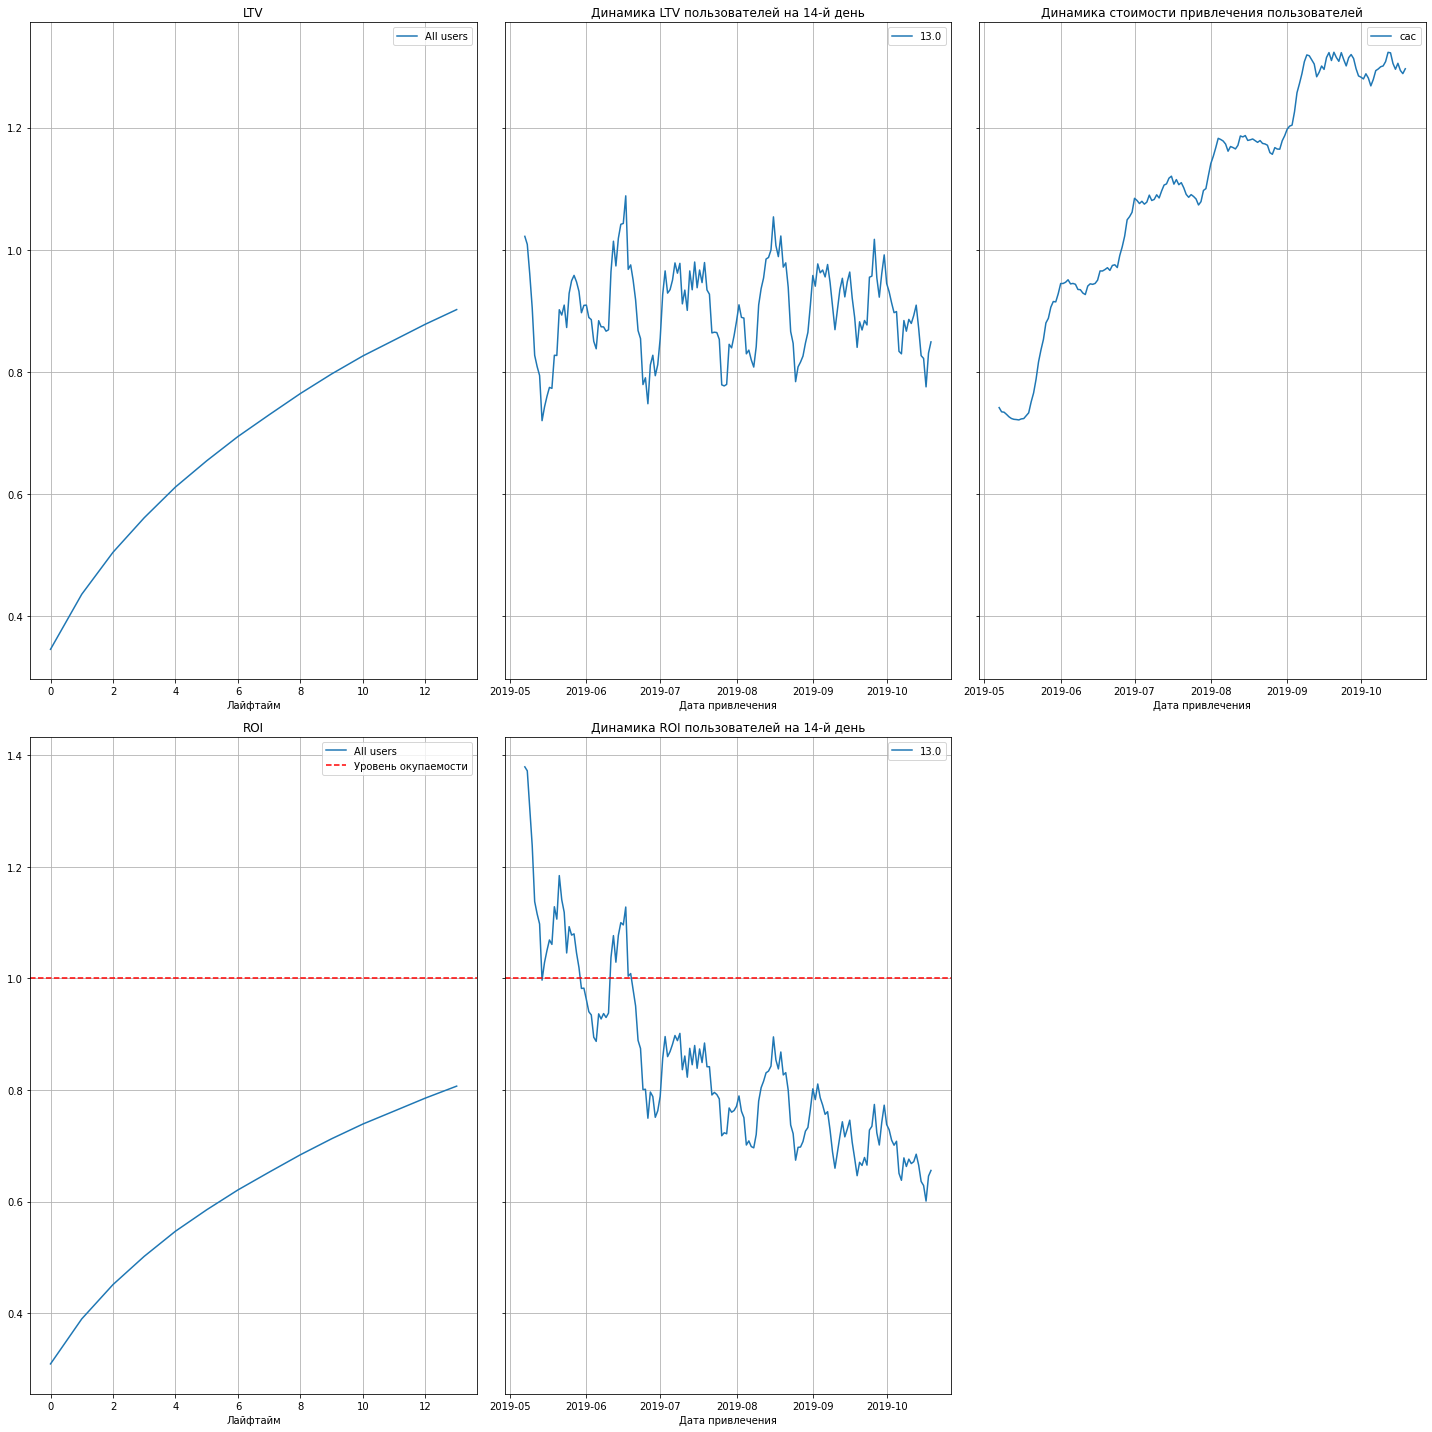

In [32]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Стоимость привлечения пользователей растет, при этом roi ниже черты окупаемости и стабильно падает в динамике

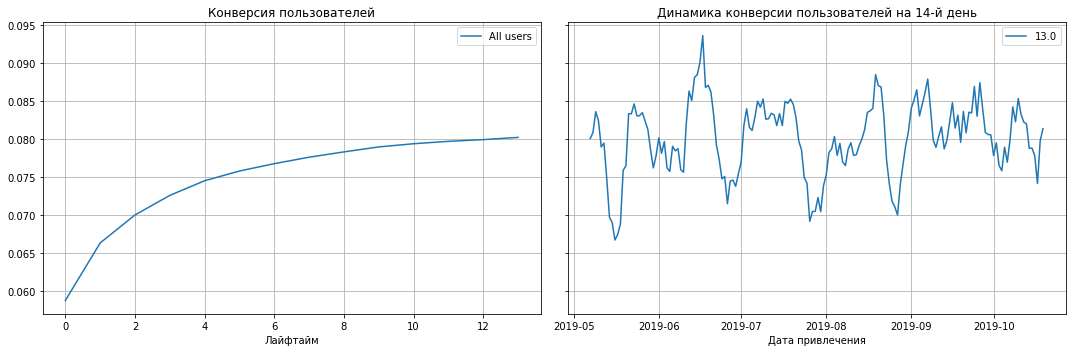

In [33]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

С середины мая до середины июня мы видим подъем конверсии, возможно в это время были сделаны вложения в рекламу

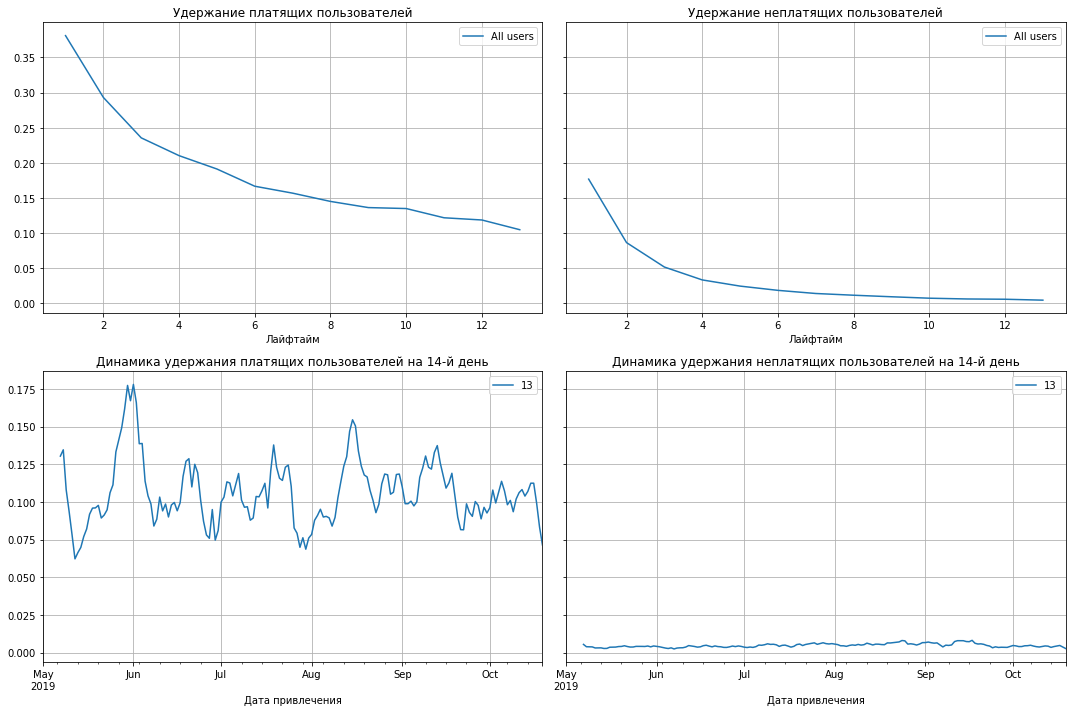

In [34]:
# смотрим удержание 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей ,как платящих, так и нет падает

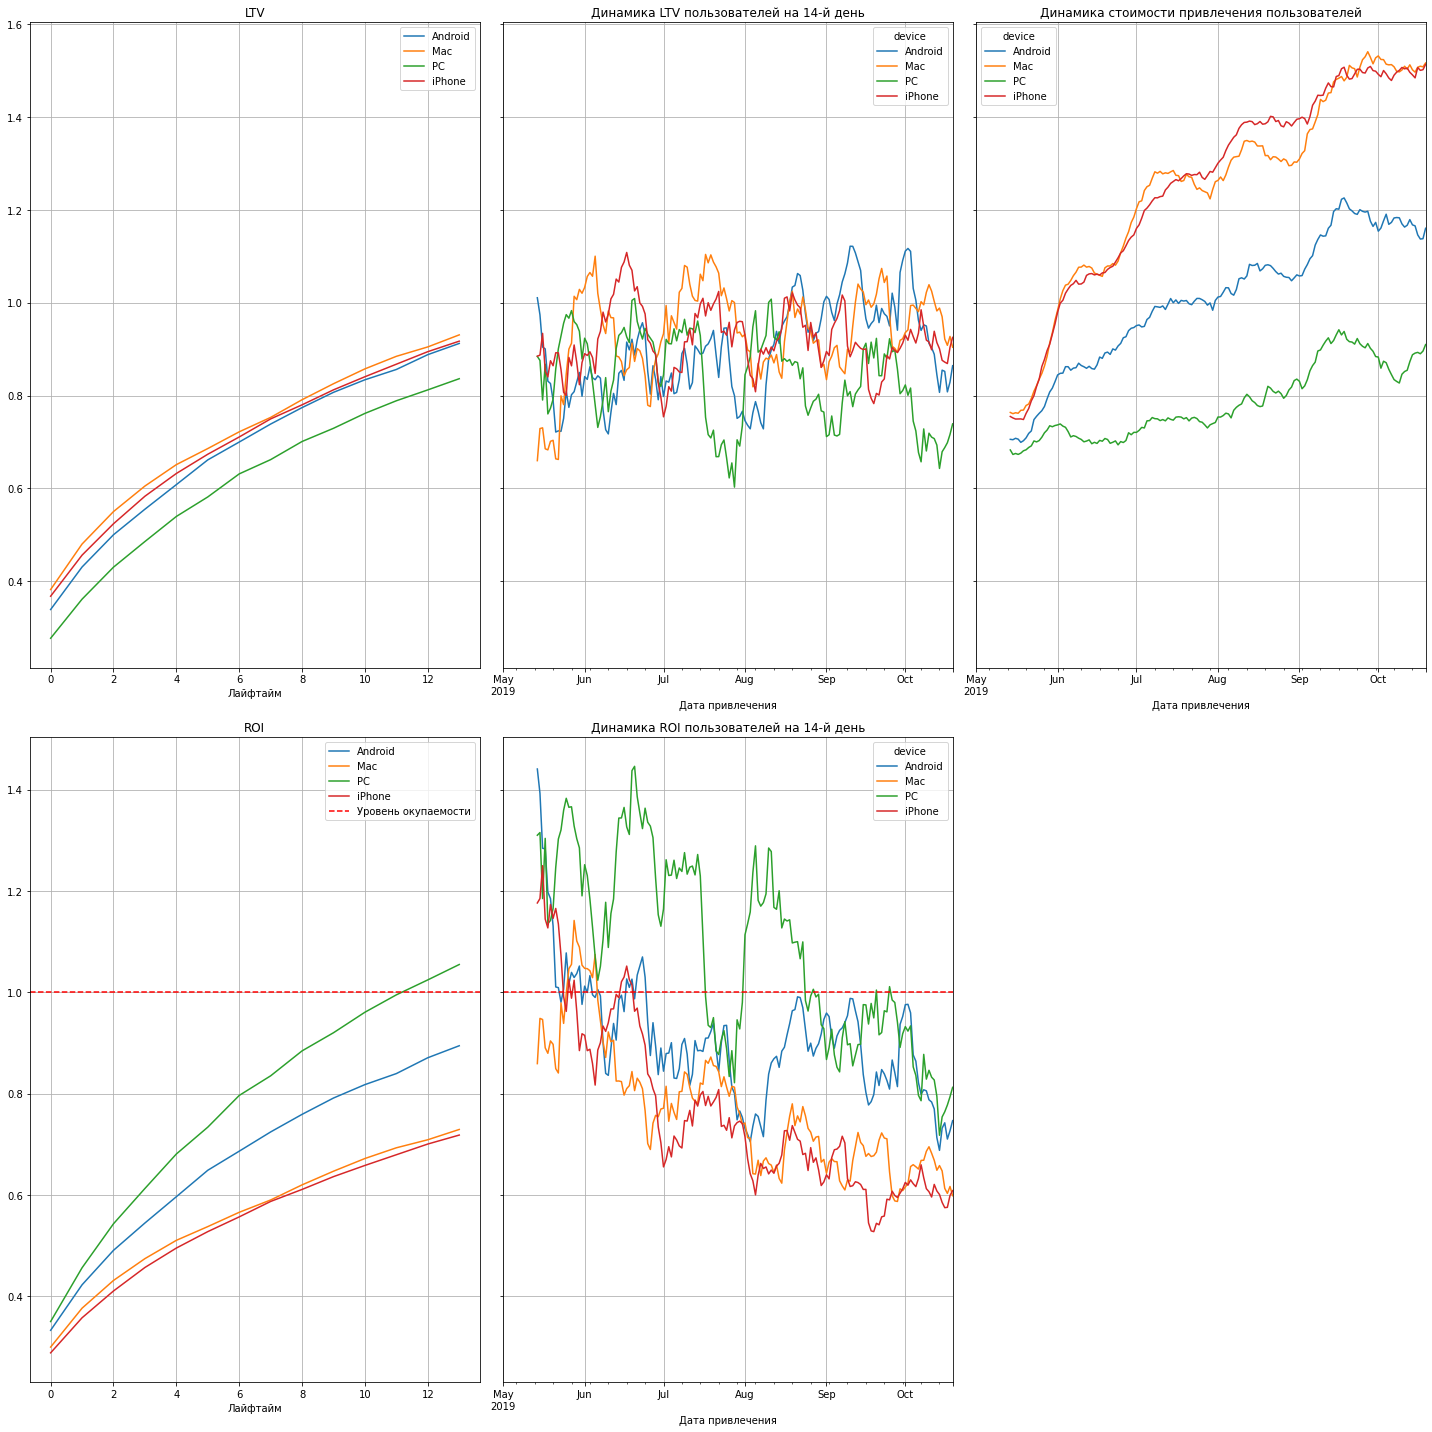

In [35]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Пользователи iphone и mac ниже черты окупаемости ,при этом в динамике roi падает по все пользователям, а стоимость привлечения растет. Единственный окупаемый канал это PC и окупается он к концу цикла

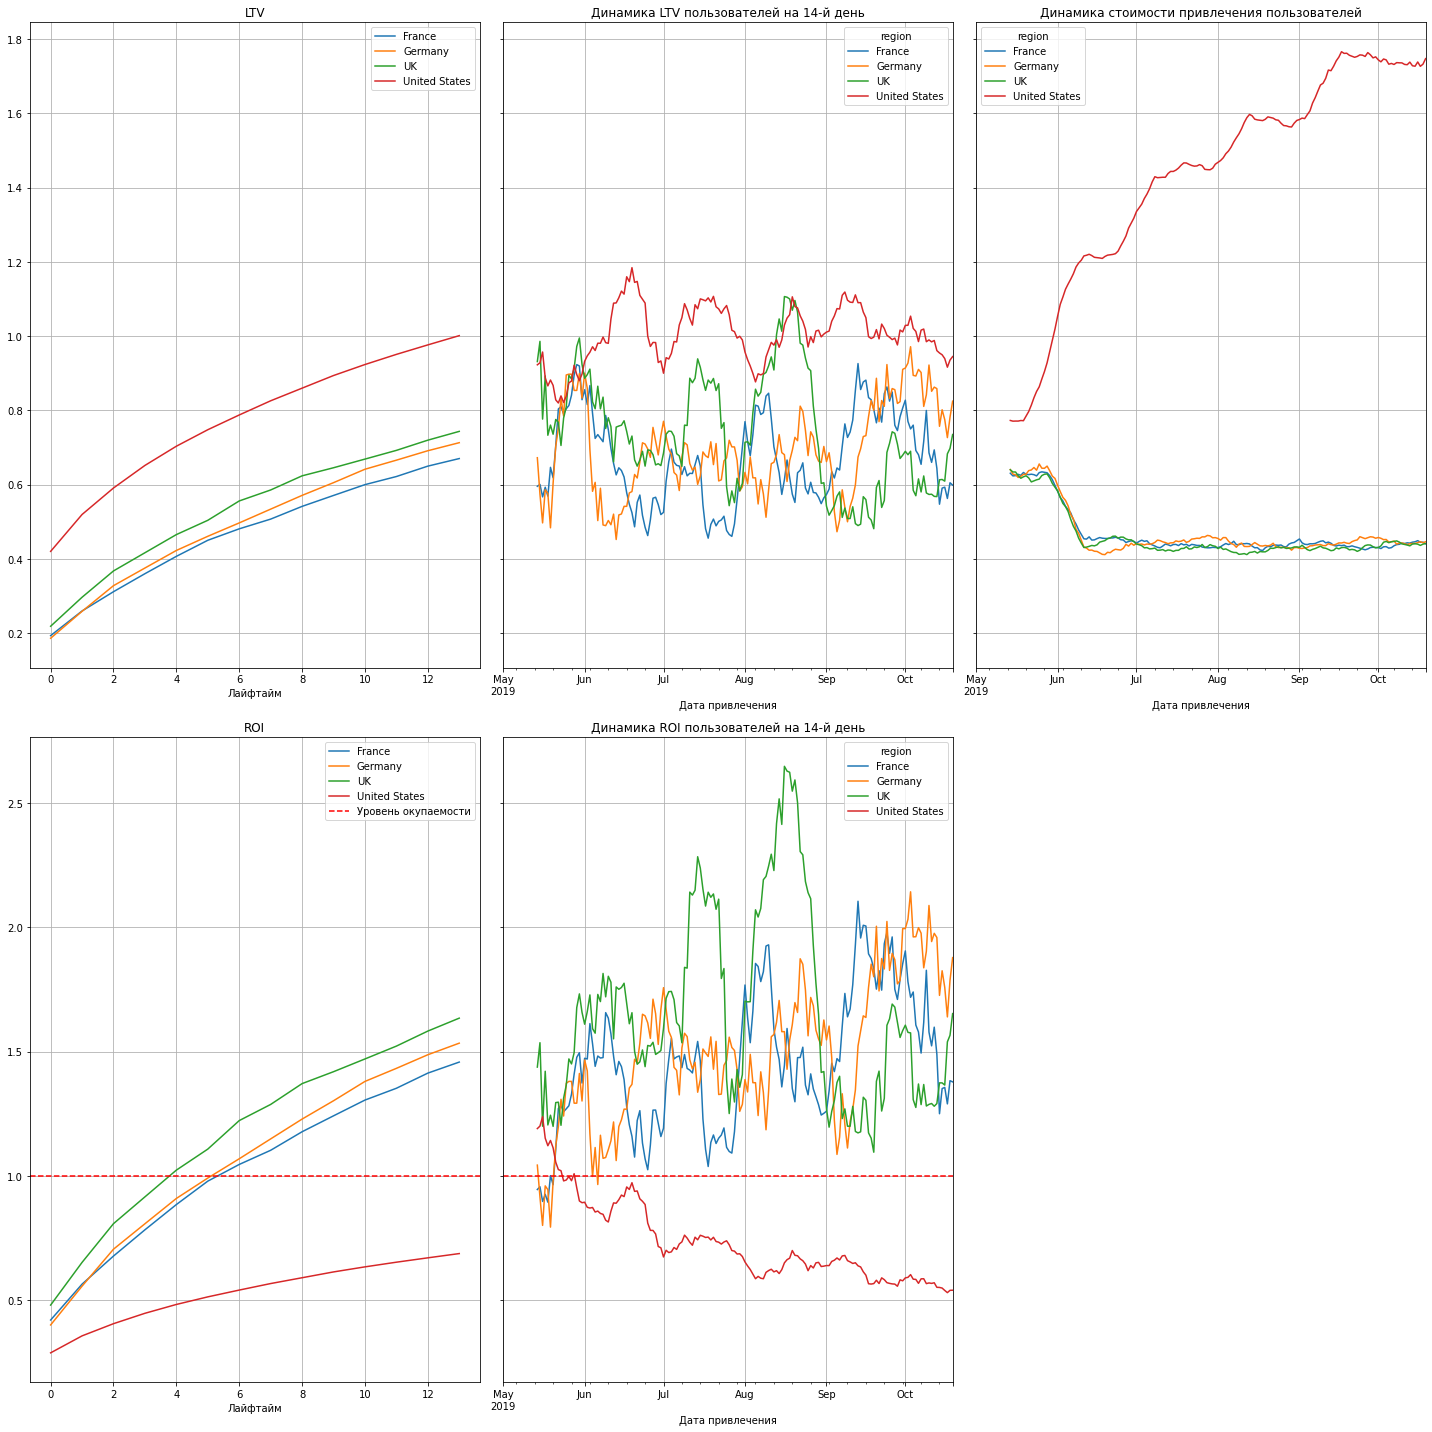

In [36]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графику мы можем сделать вывод, что затраты на рекламу сильно выросли для клиентов из США и при этом они совсем не окупаются, а в динамике roi идет на снижении, поэтому вкладывать деньги в пользователей из Америки было ошибочным решением

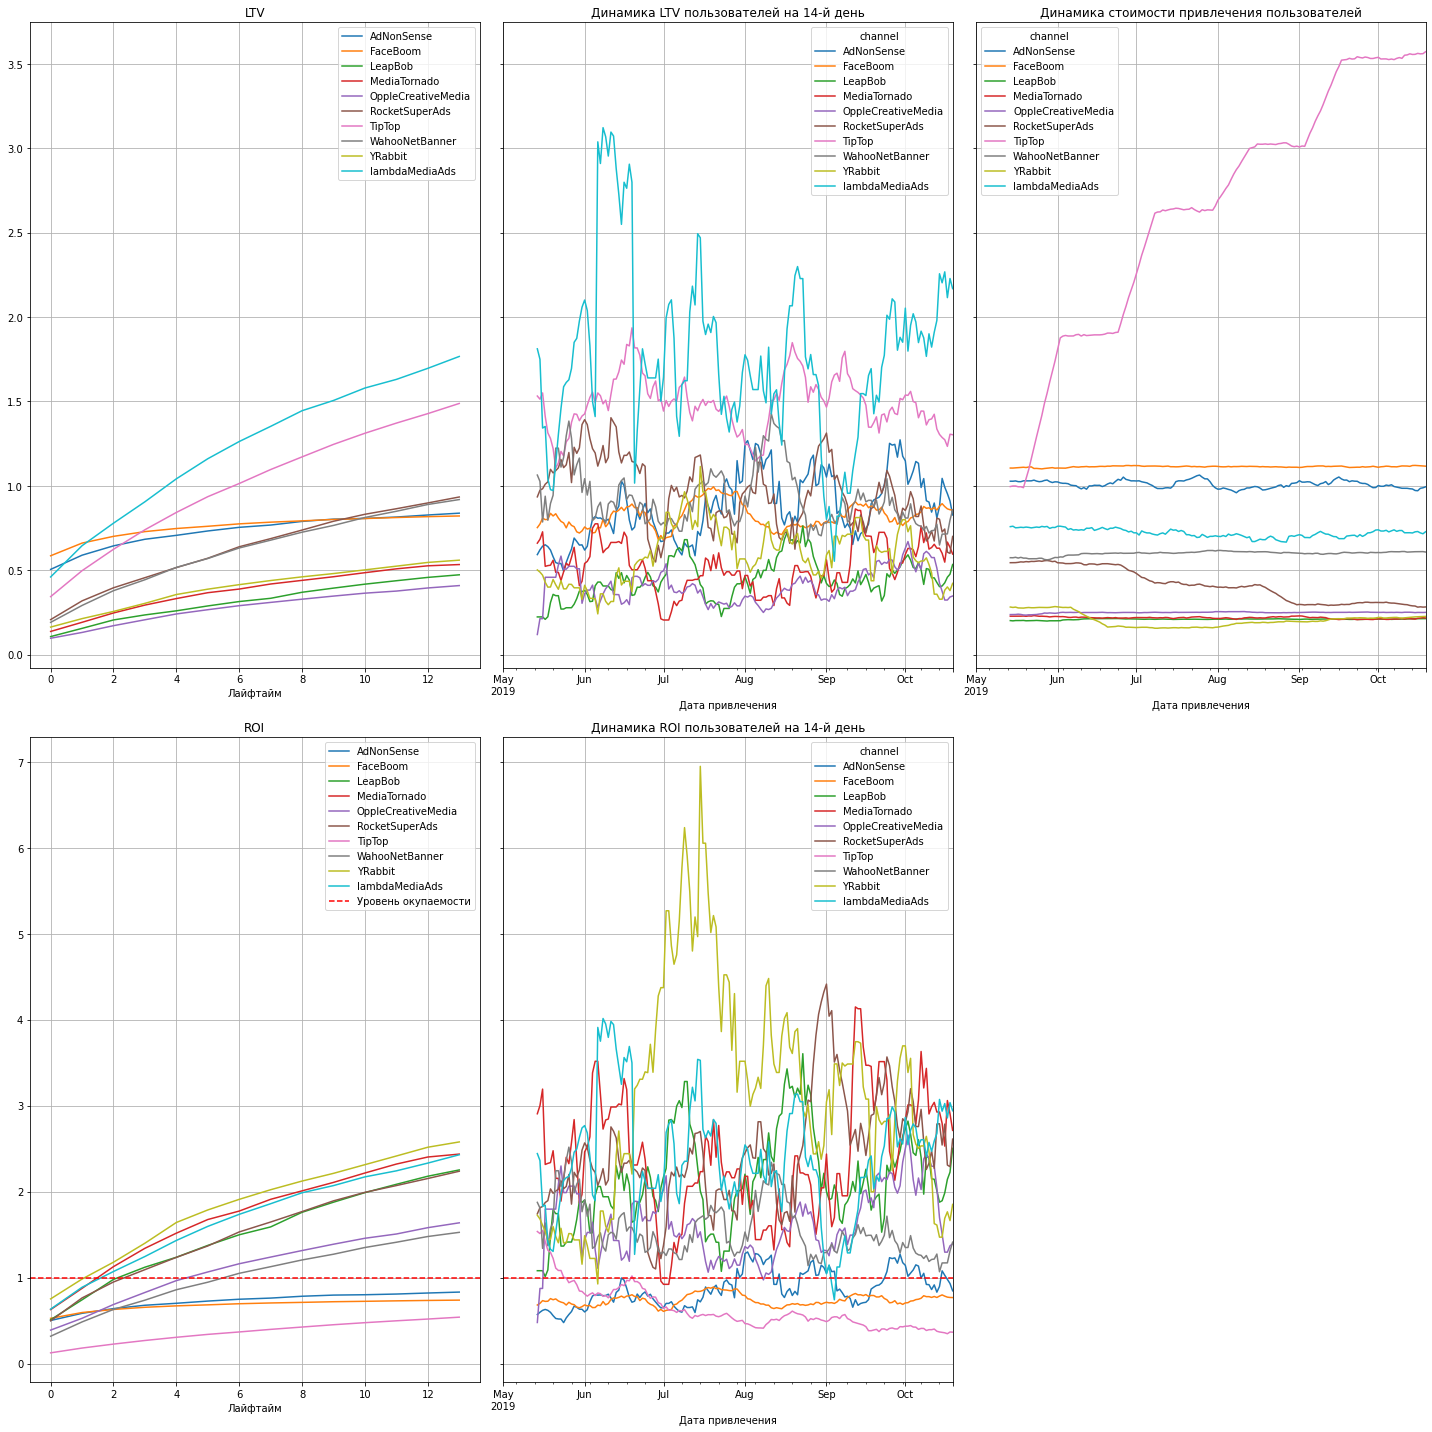

In [37]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


Канал lambdaMediaAds, несет самых "долгоживущих" пользователей. Также судя по графикам каналы Tip Top, FaceBoom и AdNonSense убыточны. Судя по всему компания решила вложится в канал привлечения Tip Top, сильно повысив траты, что не принесло ожидаемых плодов. При этом траты на привлечения новых пользователей по другим каналам примерно оставались одинаковыми. 

### Посмотрим конверсию и удержание с разбивкой по странам, регионам и устройствам

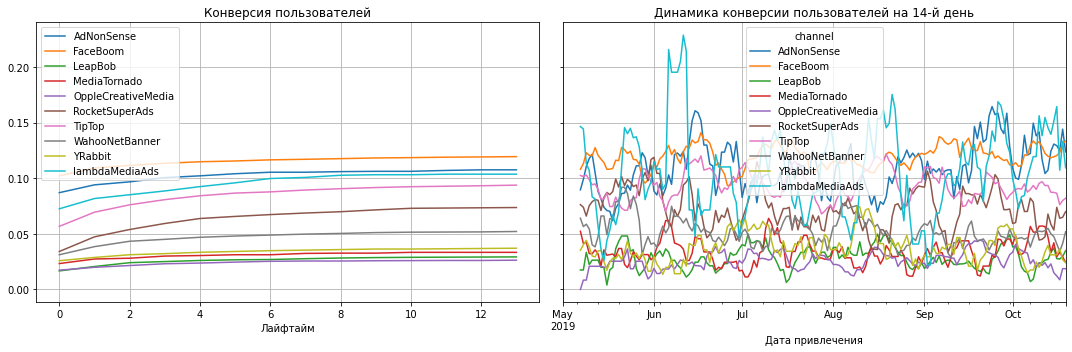

In [38]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

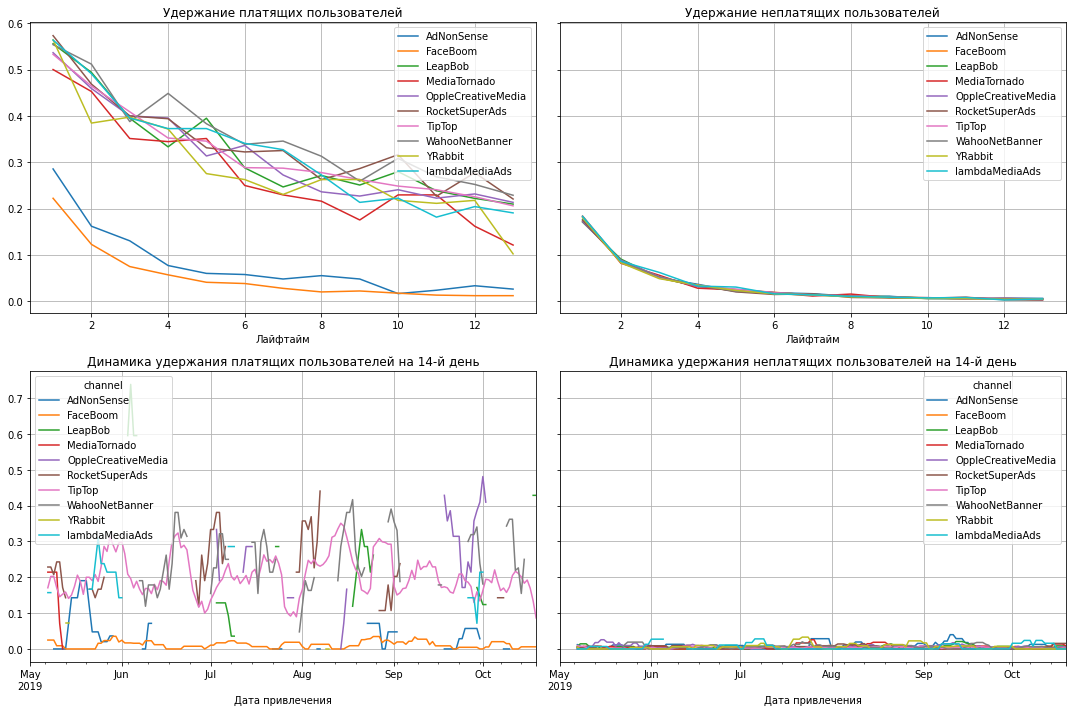

In [39]:
# смотрим удержание 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Каналы Faceboom и AdNonSense приносит недолгоживущих пользователей

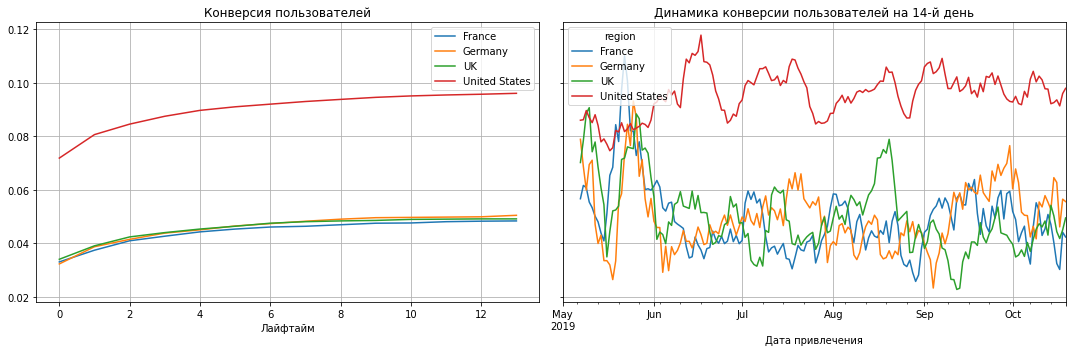

In [40]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

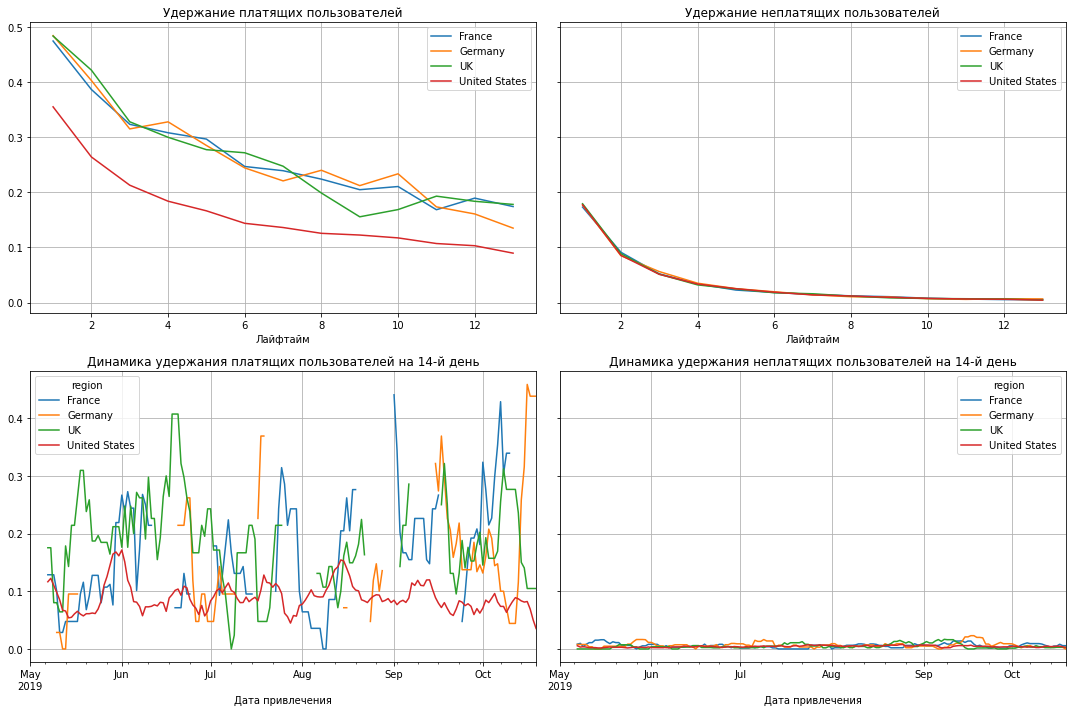

In [41]:
# смотрим удержание 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

США в числе отстающих по удержанию, но по конверсии они лидеры

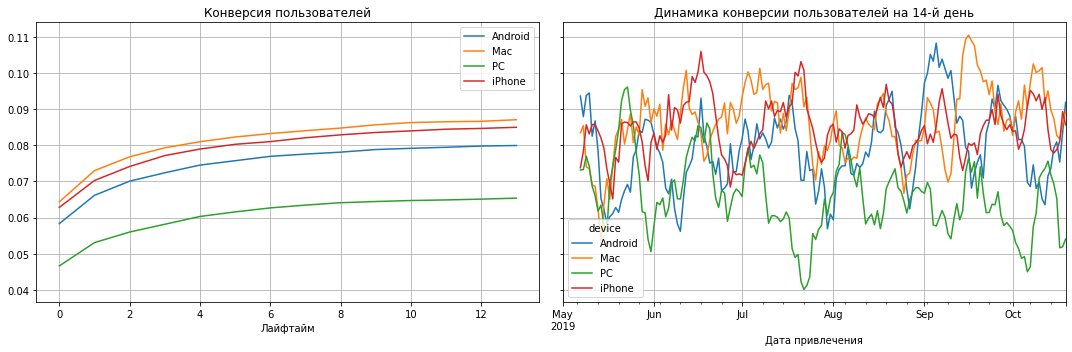

In [42]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

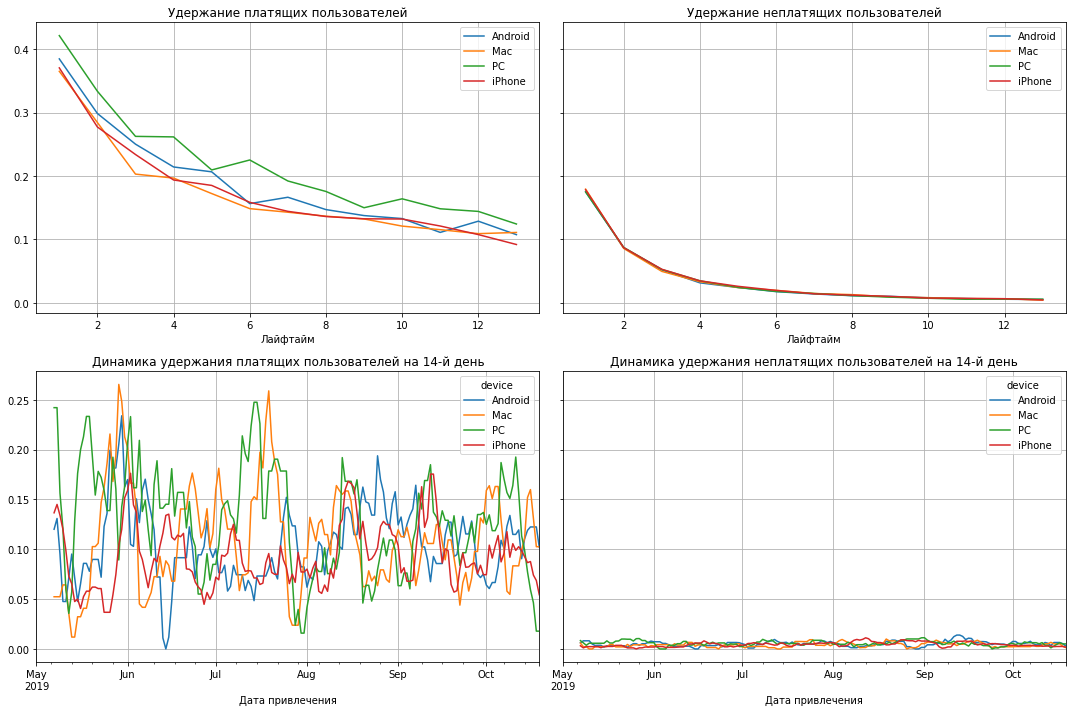

In [43]:
# смотрим удержание 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div class="alert alert-info"> <b>Различий среди неплатящих пользователей нет, тогда как у платящих самые долгоживущие пользователи PC, но у них самая низкая конверсия</b>

<div class="alert alert-info"> <b>Посмотрим динамику показателей отдельно по США </b>

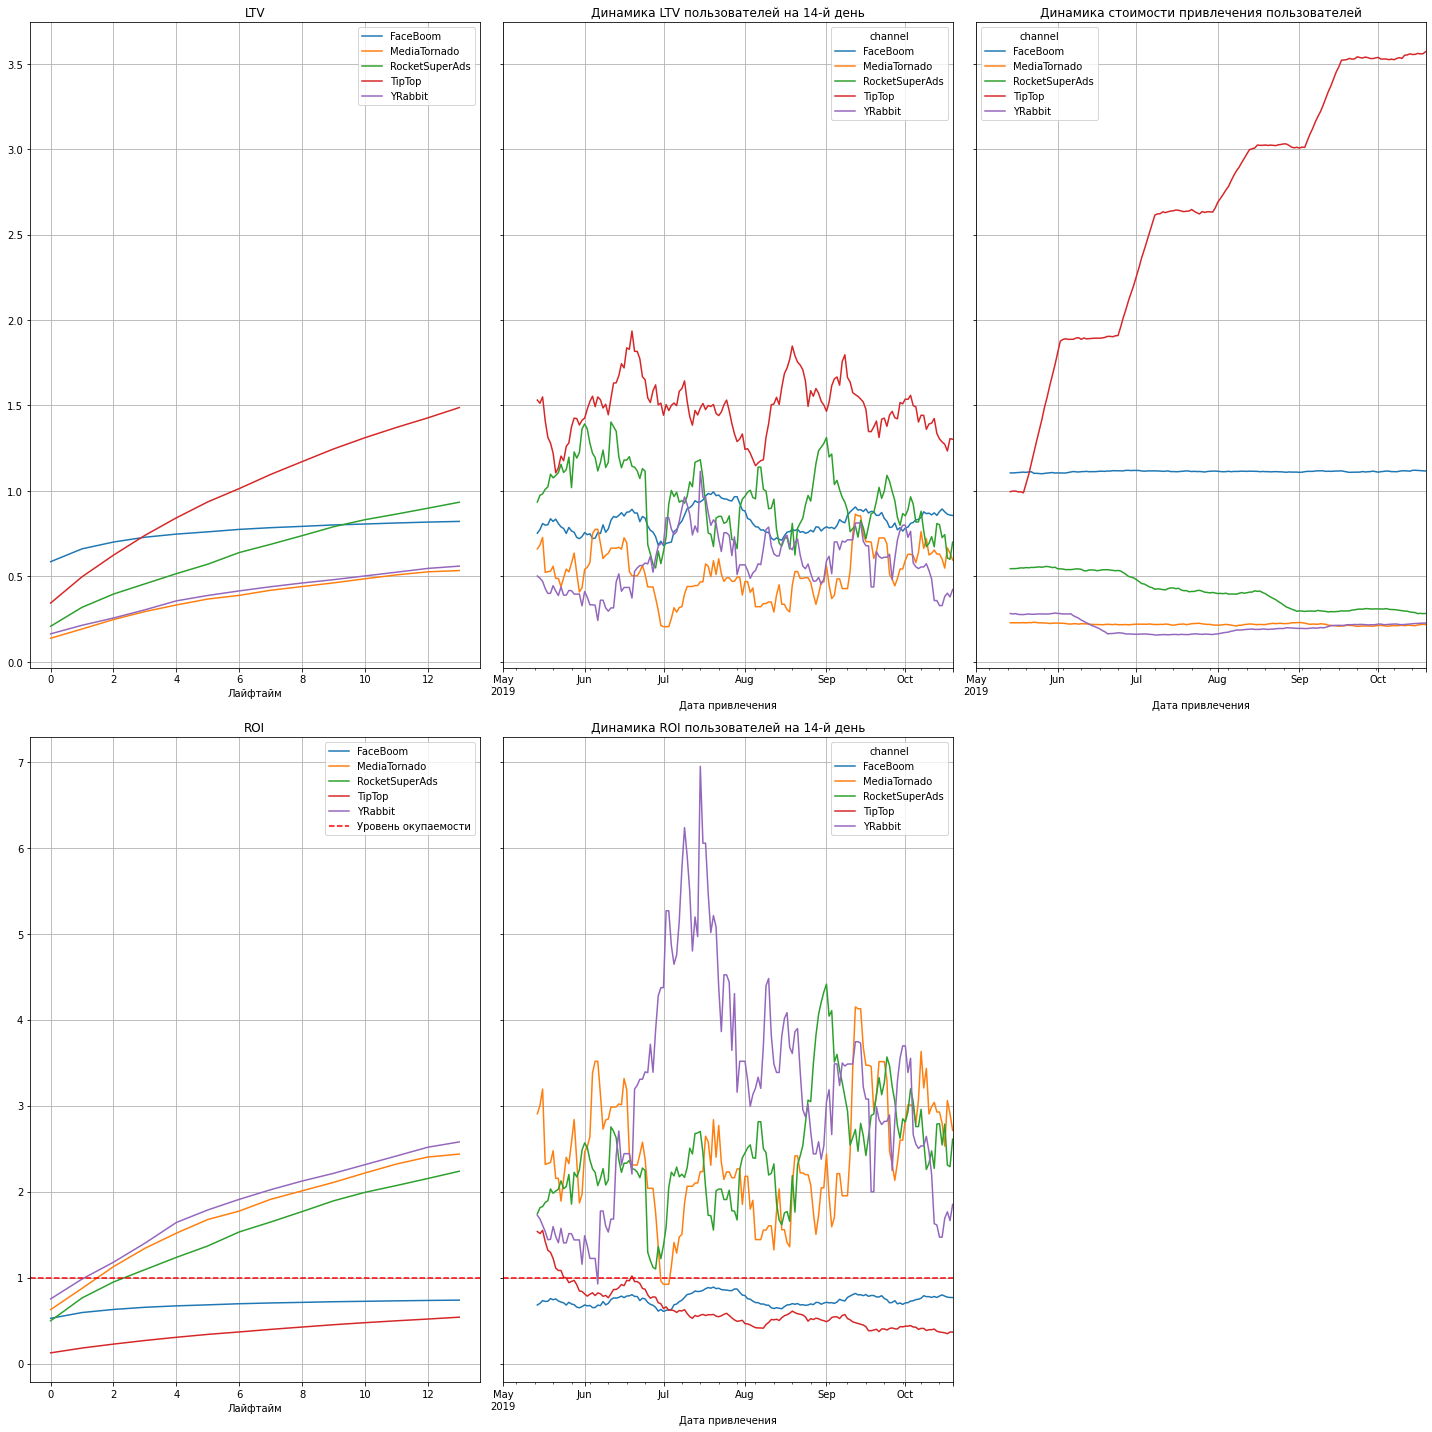

In [44]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['region'] == 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Исходя из графиков мы четко видим преспективность канала YRabbit, а также неэффективность вложений в канал TIP TOP

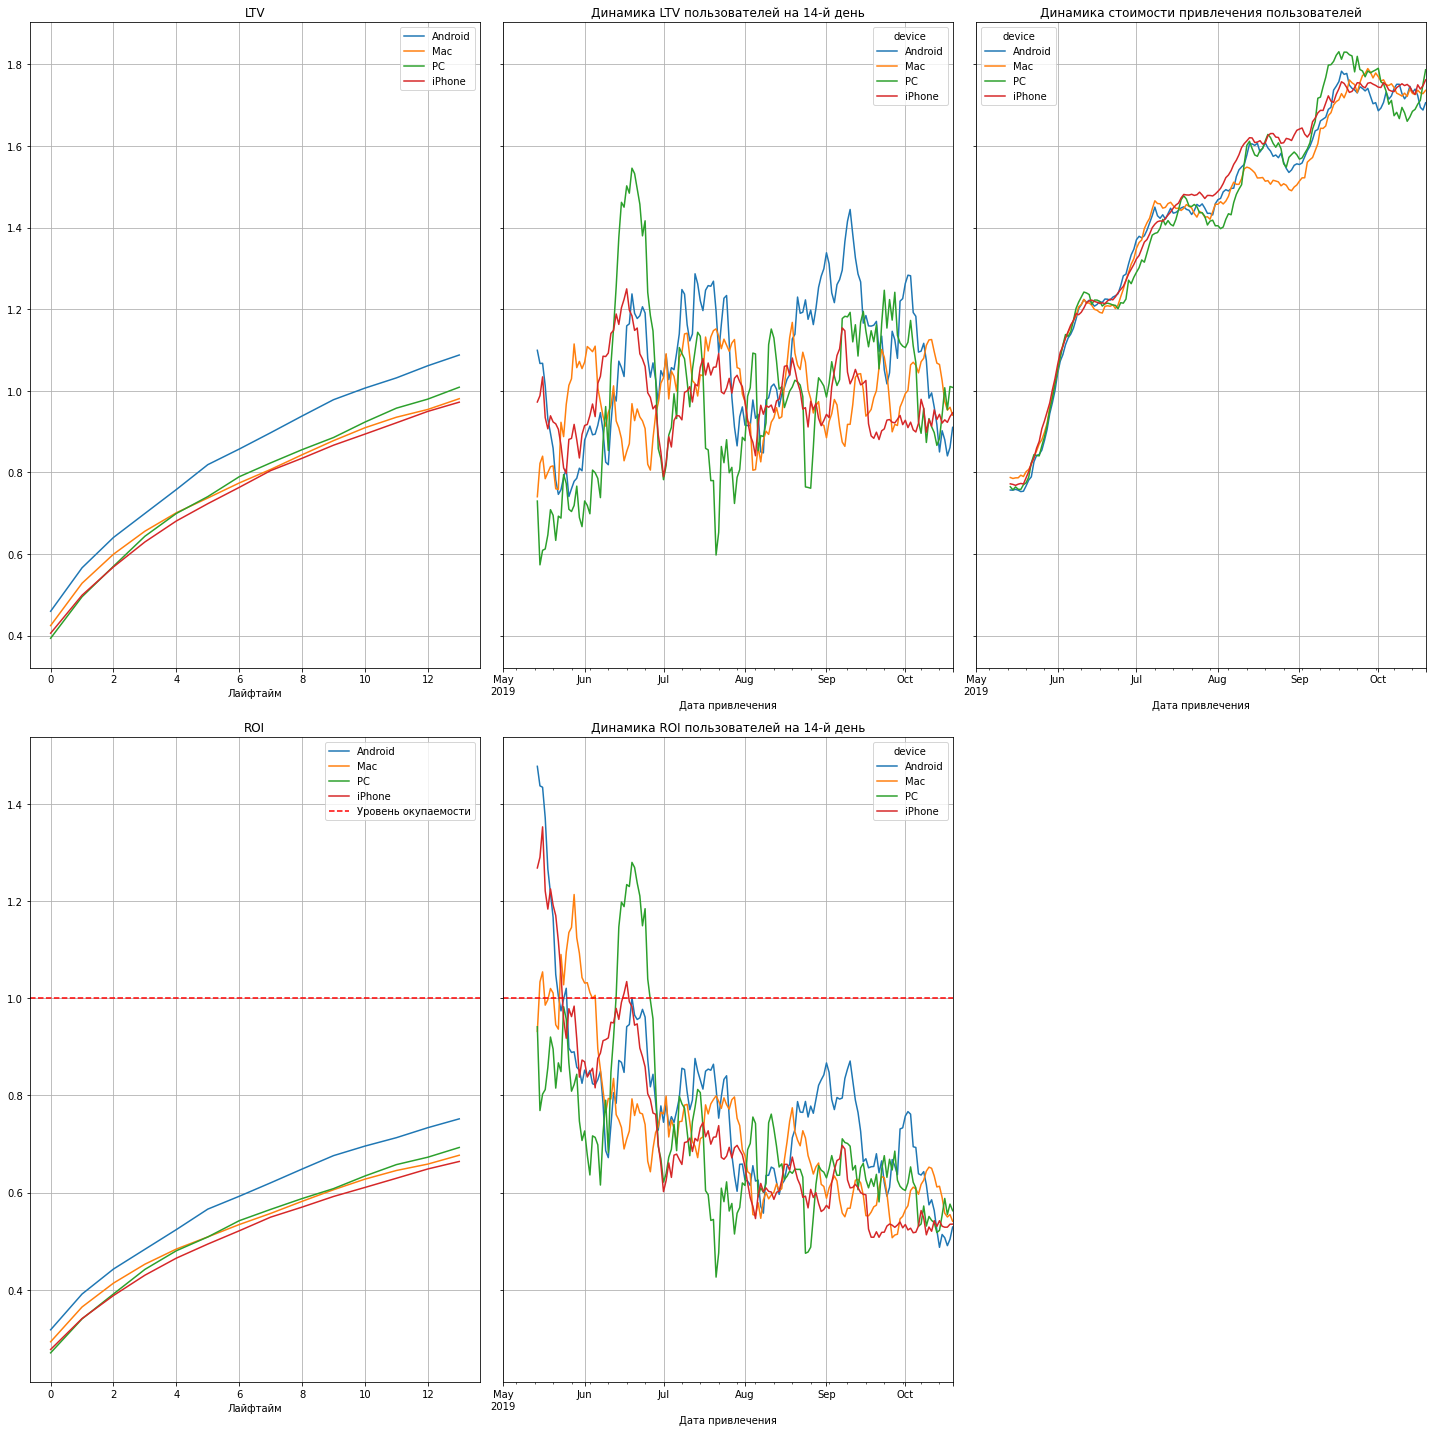

In [45]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['region'] == 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Проблем в конкретном утсройстве не обнаружено, все пользователи неокупаемы. 

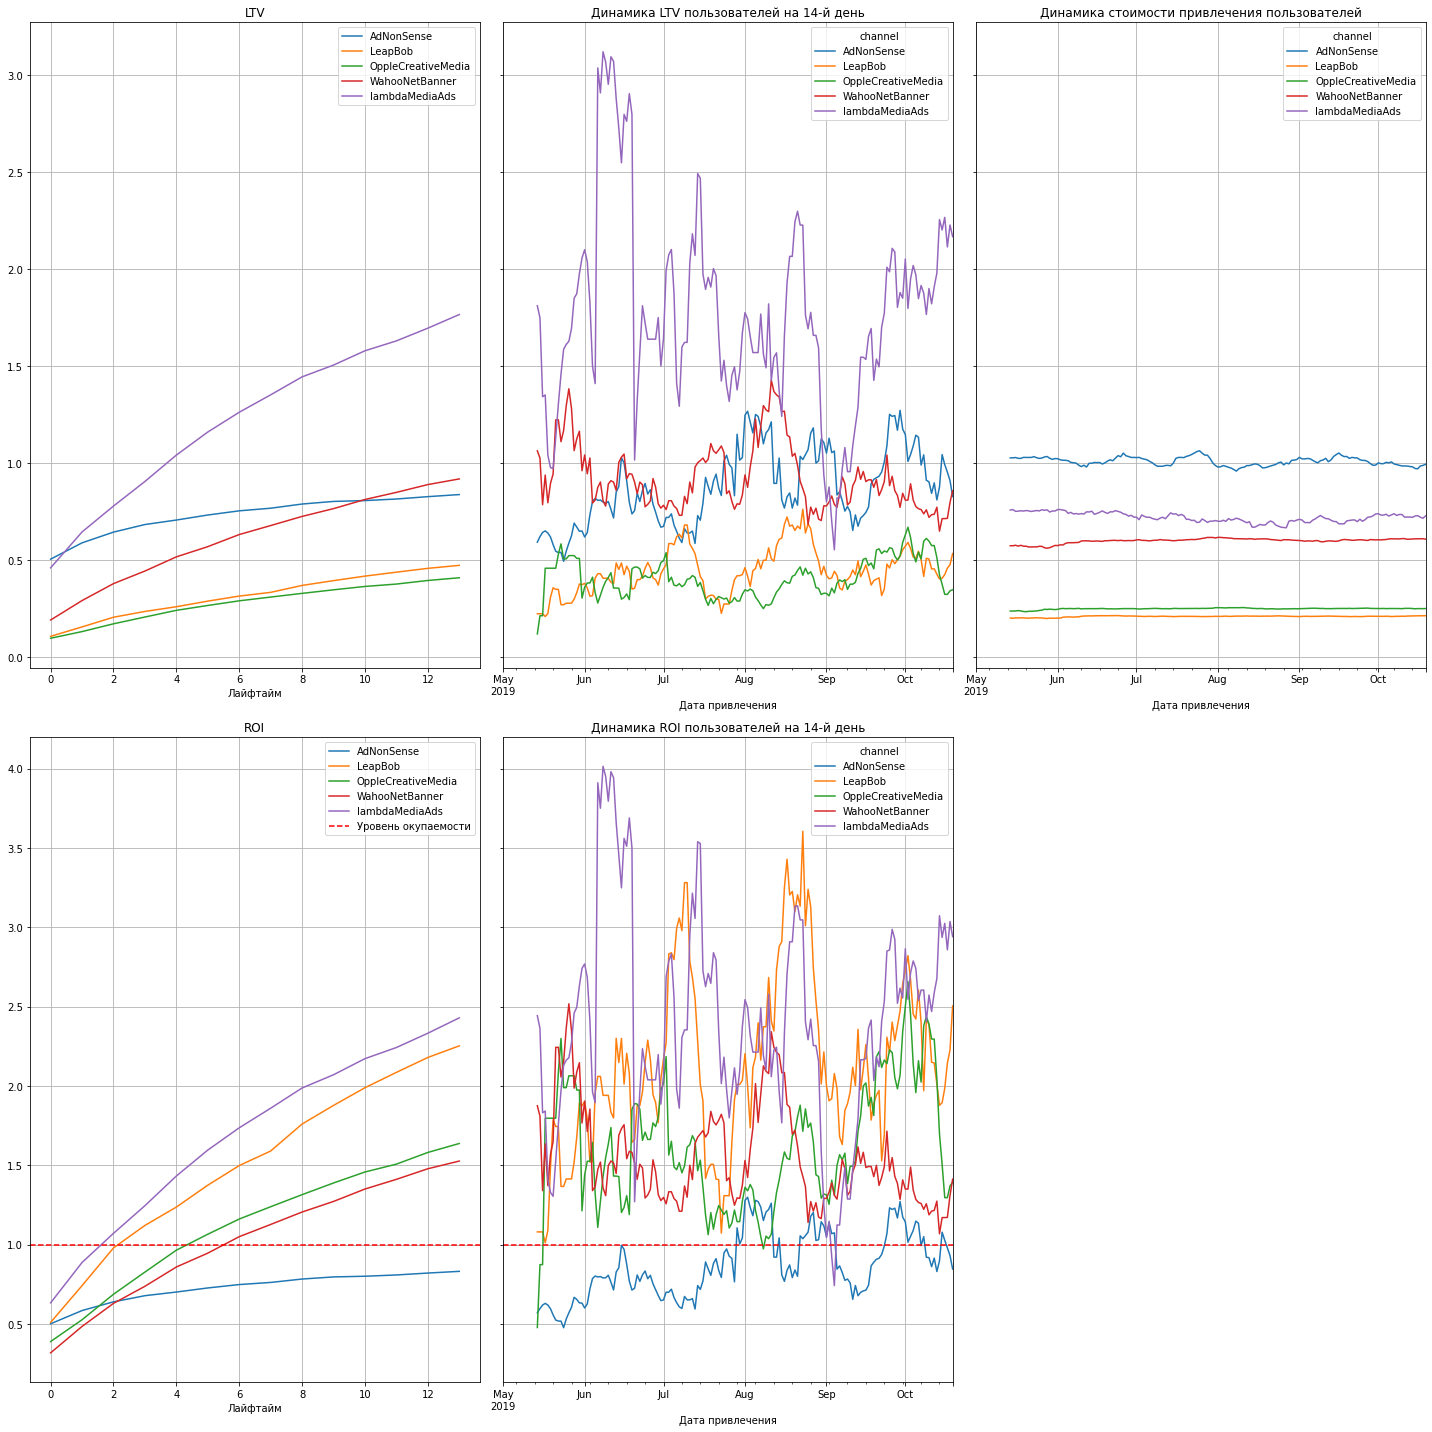

In [46]:
dimensions = ['channel']


ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['region'].isin(['UK','France','Germany'])], orders, observation_date, horizon_days, dimensions = dimensions
)

             
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

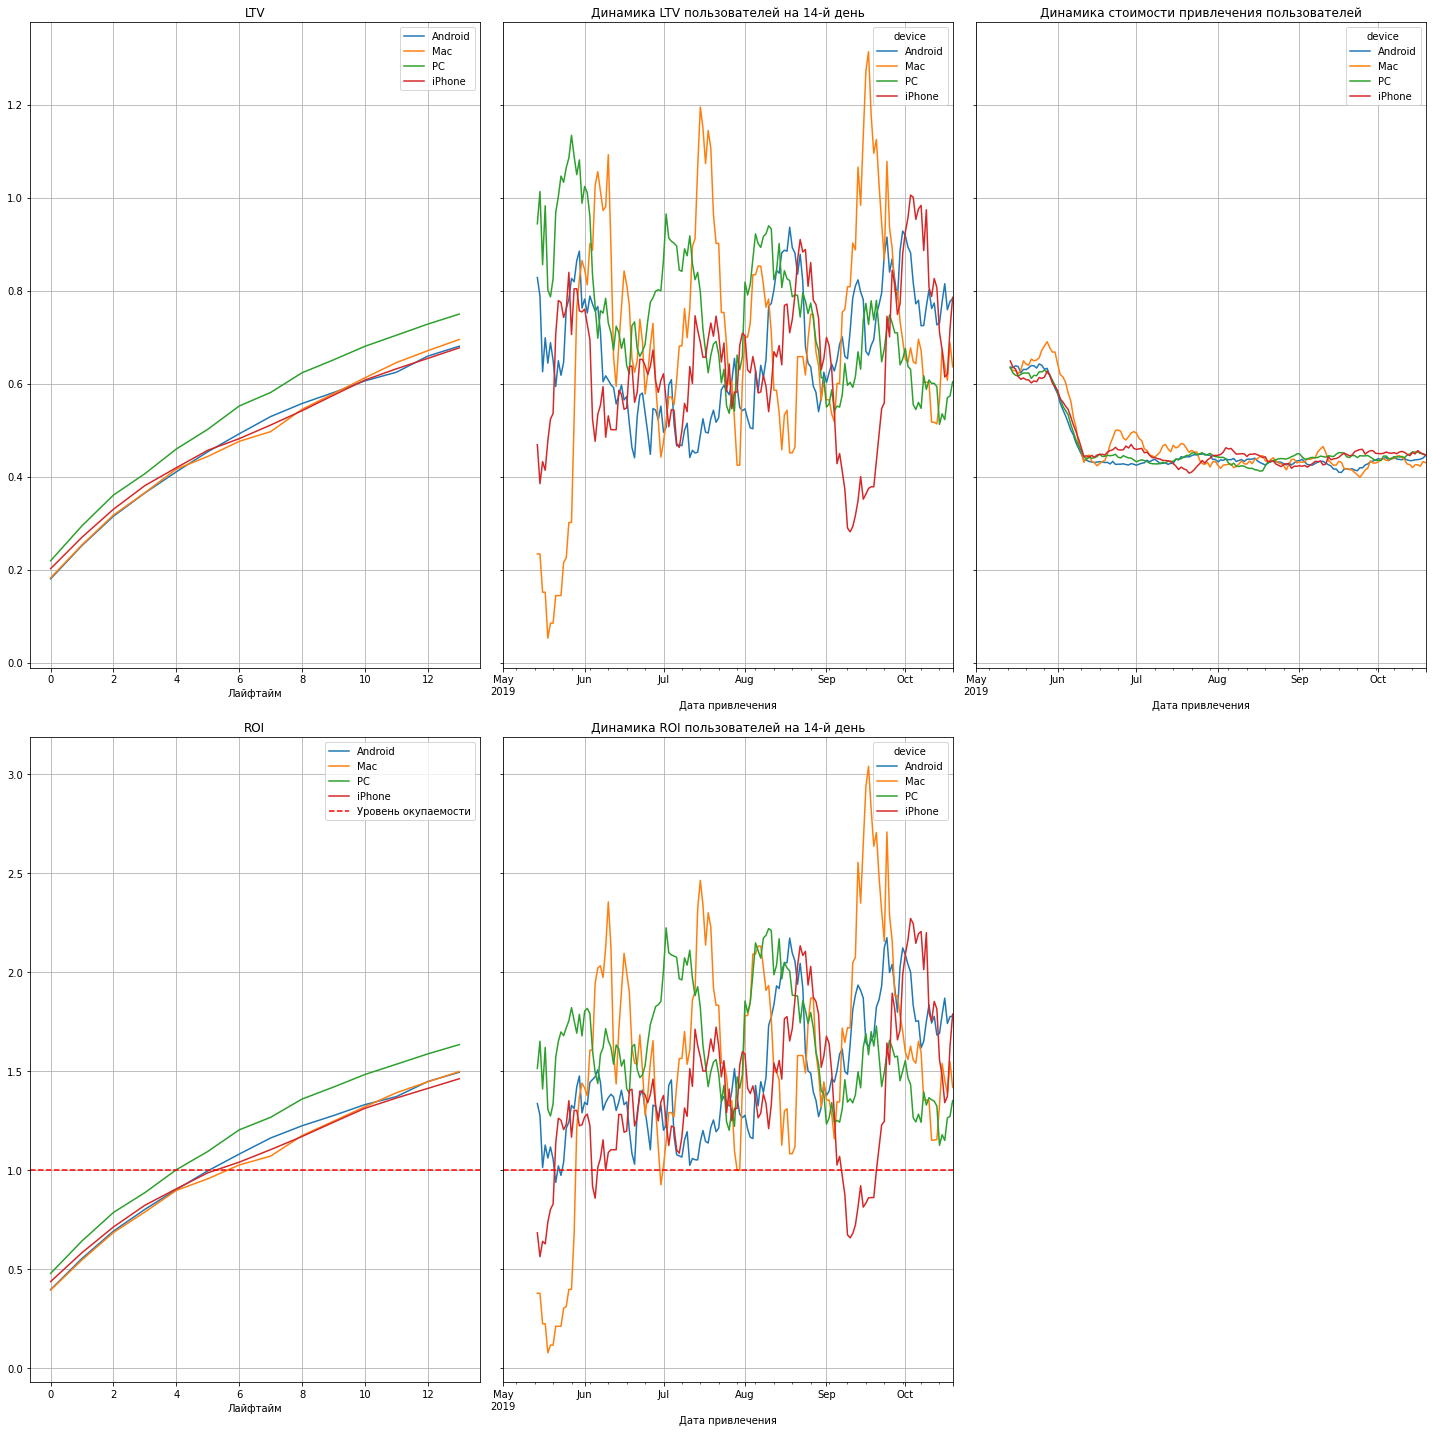

In [47]:
dimensions = ['device']


ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['region'].isin(['UK','France','Germany'])], orders, observation_date, horizon_days, dimensions = dimensions
)

             
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

На графиках мы четко видим, что канал lambdaMediaAds обладает высокой преспективой и лидирует для Европы

# Выводы   
Каналы в которые вкладывается компания не приносят прибыли.   
При этом несмотря на то, что доля платящих пользователей из Америки, с устройств iphone и mac выше всего, это не приносит компании прибыли. Так же и с каналами привлечения  FaceBoom и Tip Top.   
В рамках проведенного исследования мы рекомендуем увеличить бюджет в такие каналы привлечения как lambdaMediaAds(оттуда приходит большой процент платящих пользователей и лайфтайм пользователй этого канала высокий), а также каналы YRabbit и MediaTornado(хорошии показатели вовлеченности пользователей, при таких небольших тратах на рекламу). При этом канал YRabbit преспективен для США ,а канал lambdaMediaAds для Европы